In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [54]:
import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [4]:
train_data_dir = 'data/tc4tl_training_data_v1/tc4tl/data/train/'
train_key = pd.read_csv('data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv', sep='\t')

## Helper functions

In [5]:
def read_bluetooth_from_file(filepath):
    """Read bluetooth RSSI readings from file"""
    return pd.DataFrame([ { 'Time' : float(line.split(',')[0]), 'Rssi' : float(line.split(',')[-1]) }
              for line in open(filepath).read().split('\n')
              if 'Bluetooth' in line ])

In [46]:
def chirp_sequence(df):
    """Return a sequence of values containing average RSSI reading of each chirp"""
    chirps, rssi = [], []
    for idx, t in df.iterrows():
        if idx > 0 and t.Time - df.Time.loc[idx - 1] > 1:
            chirps.append(np.array(rssi).mean())
            rssi = []
        else:
            rssi.append(-t.Rssi)
    return chirps + [np.array(rssi).mean(), ]

In [7]:
train_key

,fileid,phone_carriage_state,distance_in_meters,step_size_in_sec,coarse_grain
0,aaadbuvp_tc4tl20.csv,pocket_hand,1.8,50,Y
1,aaamkcii_tc4tl20.csv,pocket_pocket,3.0,80,N
2,aabqtowt_tc4tl20.csv,hand_hand,1.2,60,N
3,aadkjwss_tc4tl20.csv,pocket_pocket,1.8,20,N
4,aafzrgzt_tc4tl20.csv,hand_hand,1.8,60,Y
...,...,...,...,...,...
15547,zzwcoemu_tc4tl20.csv,pocket_hand,1.2,80,N
15548,zzwoqxuc_tc4tl20.csv,hand_hand,4.5,70,N
15549,zzymwbbb_tc4tl20.csv,pocket_pocket,1.2,10,N
15550,zzzflikz_tc4tl20.csv,hand_hand,1.8,100,Y


## Calculate Mean Chirp Sequences across training set

In [8]:
chirps = {}
for idx, row in tqdm(train_key[train_key.coarse_grain == 'Y'].iterrows()):
    df = read_bluetooth_from_file(os.path.join(train_data_dir, row.fileid))
    chirps[row.fileid] = chirp_sequence(df)

231it [00:35,  6.86it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
529it [01:22,  7.87it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
5184it [12:33,  6.88it/s]


## Pad Chirp Sequence

In [13]:
maxlen = max([len(v) for v in chirps.values()])

In [40]:
X, y = [], []
for fileid, seq in tqdm(chirps.items()):
    if np.isnan(seq).sum() == 0:
        _y = train_key[train_key.fileid == fileid].distance_in_meters.item()
        y.append(str(_y))
        X.append(seq + [0]*(maxlen - len(seq)))

100%|██████████| 5184/5184 [00:06<00:00, 813.76it/s]


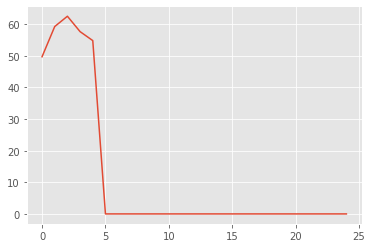

In [75]:
plt.plot(X_fg[0])

In [76]:
y_fg[0]

'3.0'

## Fit a Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
ypred = rf.predict(X_test)

In [45]:
from sklearn.metrics import classification_report


print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         1.8       0.93      0.97      0.95       779
         4.5       0.97      0.92      0.94       759

    accuracy                           0.95      1538
   macro avg       0.95      0.95      0.95      1538
weighted avg       0.95      0.95      0.95      1538



# Fine-Grained 

In [58]:
chirps_fg = {}
for idx, row in tqdm(train_key[train_key.coarse_grain == 'N'].iterrows()):
    df = read_bluetooth_from_file(os.path.join(train_data_dir, row.fileid))
    chirps_fg[row.fileid] = chirp_sequence(df)

545it [00:41, 15.12it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
10368it [12:58, 13.32it/s]


## Pad Chirp Sequence (FG)

In [59]:
maxlen = max([len(v) for v in chirps_fg.values()])
maxlen

25

In [60]:
X_fg, y_fg = [], []
for fileid, seq in tqdm(chirps_fg.items()):
    if np.isnan(seq).sum() == 0:
        _y = train_key[train_key.fileid == fileid].distance_in_meters.item()
        y_fg.append(str(_y))
        X_fg.append(seq + [0]*(maxlen - len(seq)))

100%|██████████| 10368/10368 [00:12<00:00, 808.19it/s]


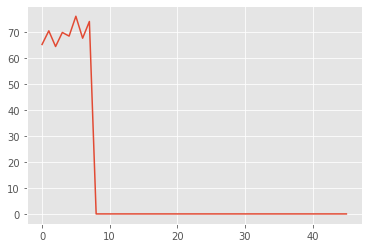

In [70]:
plt.plot(X[-2])

In [66]:
y[-2]

'4.5'

## Evaluation

In [71]:
X_train_fg, X_test_fg, y_train_fg, y_test_fg = train_test_split(X_fg, y_fg, test_size=0.3, random_state=69)
rf_fg = RandomForestClassifier()
rf_fg.fit(X_train_fg, y_train_fg)

RandomForestClassifier()

In [72]:
ypred_fg = rf_fg.predict(X_test_fg)

In [74]:
print(classification_report(y_test_fg, ypred_fg))

              precision    recall  f1-score   support

         1.2       0.85      0.91      0.88       794
         1.8       0.83      0.77      0.80       795
         3.0       0.82      0.82      0.82       730
         4.5       0.87      0.87      0.87       774

    accuracy                           0.84      3093
   macro avg       0.84      0.84      0.84      3093
weighted avg       0.84      0.84      0.84      3093

